# Getting risk insights on Tornados with PySpark on IBM Db2 Warehouse
### Visual analysis of tornado records in the USA for risk assessment

This notebook shows you how to use IBM Db2 Warehouse to efficiently handle, analyze and visualize geographic data with PySpark. It provides you with the tools to launch your own Spark application with IBM Db2 Warehouse.
You will learn how to connect to Db2, launch a Spark application, load data from Db2 and manipulate dataframes. 

Our present use case is tornados in the USA and a potential industrial application of this use case is tailored insurance policy making. Based on the history of tornados in the region of your insurance holders, predict how likely they are to encounter a natural disaster and adapt their policy according to the risk they really face.

This notebook runs with a PySpark kernel. Visualizations are outputed locally.

#### Contents 

[1. Configure your resources](#imports)

[2. Load the data](#load_tornado)

[3. Explore the data](#explore_tornado)
* [a. Overview: repartition of tornados in the US](#overview)
* [b. Heat map: get insights in the hotspots](#heatmap)
* [c. Density map per state: identify where the risk hide](#density_map)

[4. Machine Learning: Tornado Clustering](#ML)
* [a. Build tornado clusters in Texas](#clusters_texas)
* [b. Assess risk for home insurance holders in Texas](#insurance_holders)

[5. Deploy your own application](#you)

<a id="imports"></a>
## 1. Configure your resources 

#### Configure Livy 

Livy is an open-source REST service for Apache Spark. You can use it with sparkmagic in a Jupyter notebook to execute Spark jobs easily. Read more on the official Apache Livy page : https://livy.apache.org/.

Sparkmagic (https://github.com/jupyter-incubator/sparkmagic) enables to work with remote Spark clusters through Livy in Jupyter notebooks. It will run a Spark job through Livy when you write Spark code on your local Jupyter client. This means you can run a Spark job from your own Jupyter notebook, which is running on your local host.

Let's open a terminal window and execute the following commands:
> pip install sparkmagic

> jupyter nbextension enable --py --sys-prefix widgetsnbextension

Then retrieve installation directory of sparkmagic with
> pip show sparkmagic

Move to this directory to install the notebook kernels for Scala, R and Python with:
> cd your_install_dir

> jupyter-kernelspec install sparkmagic/kernels/sparkkernel

> jupyter-kernelspec install sparkmagic/kernels/sparkrkernel

> jupyter-kernelspec install sparkmagic/kernels/pysparkkernel

Create the config.json file for the sparkmagic configuration file in your home directory with
> cd 

> mkdir .sparkmagic

> cd .sparkmagic

> wget https://raw.githubusercontent.com/jupyter-incubator/sparkmagic/master/sparkmagic/example_config.json

Create the config.json file as a copy of example_config.json
> cp example_config.json config.json

Edit the config.json file and specify username, password and url of the IAAS system in the „credentials”-sections of the 3 kernels. "8998" is the default Livy server port. As value for the “auth” attribute enter “Basic_Access”
Example: 
```
{
 "kernel_python_credentials" : {
    "username": "your_name",
    "password": "your_password",
    "url": "http://yoururl:8998",
    "auth": "Basic_Access"
 },
 ...
```
Also remove the following section (lines 52 to 55), because the configuraion of Spark is apapted automatically to the available resources in the Db2 Warehouse container:
```
"session_configs": {
    "driverMemory": "1000M",
    "executorCores": 2
  },
```
In case you want to change these defaults you can use the "%%configuration" magic.
```
%%configure -f 
{"executorCores": 16}
```

You can now start the Jupyter notebook with
> jupyter notebook

In the notebook you can start one of the following kernels: PySpark, Spark or R. 
You're ready!

#### Start a Spark session

In [1]:
import pandas as pd
import numpy as np

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
24,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Preparation of the input data

The following cell uses the ibmdbpy library to establish a connection from this notebook to the bludb database. The cell prepares the input data based on sample tables that are available in every Db2 Warehouse container out of the box.

Here we check if the tables containing data about tornados and home insurance holders have already created, if not we build them.

In [2]:
from ibmdbpy import IdaDataBase
idadb =IdaDataBase('bludb')

# create table if does not exist already

statement=idadb.ida_query("create table if not exists tornado as ( " +
         " select objectid,yr,mo,dy, time, cast(slat as float) as slat,cast(slon as float) as slon, " +
         "        elat,elon,cast (len as float) as len,cast(wid as float) as wid,st,cast(mag as float) as mag " +
         " from samples.geo_tornado ) with data")
      

statement=idadb.ida_query("create table if not exists texas_customers as ( " +
         " select b.objectid, b.name, b.insurance_value, db2gse.st_x(b.shape) lon, db2gse.st_y(b.shape) lat " +
         "     from samples.geo_county a, samples.geo_customer b " +
         "     where a.statefp='48' and db2gse.st_within(b.shape, a.shape) = 1 " +
         " ) with data")
idadb.close()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Connection closed.

*Note : if you obtain the error: "No module named 'ibmdbpy'"  follow these steps:*

Connect to the Db2 Warehouse node *host* under userid *user* with
> ssh -p 50022 user@host 

Install the ibmdbpy package for your userid with

> spark-pip install --user ibmdbpy

Important note : use spark-pip instead of pip to installl ibmdbpy

Now, run the above cell again.

You can check installation with command "spark-pip show ibmdbpy"

You find further details about the installation of Python packages on Db2 Warehouse and IBM Integrated Analytics System under https://www.ibm.com/support/knowledgecenter/SSCJDQ/com.ibm.swg.im.dashdb.doc/learn_how/deploying_python.html

#### Local imports for visualization

Note : check if you have magics with __%%help__. Here you need __%%local__ and __%%sql__.

In order to display the plots within this notebook, we use __%matplotlib inline__. If you like to display the images in separate windows, just comment out this line.

In [3]:
%%local
%matplotlib inline

import pandas as pd
import numpy as np
import geopandas 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy import ndimage
import matplotlib.pylab as pylab

<a id="load_tornado"></a>
## 2. Load the data

Use your Spark session to read the training data using the IDAX data source.

The input data are all recorded tornados in USA between 1950 and 2013. It is taken from http://www.spc.noaa.gov/.

In [4]:
df = spark.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="TORNADO") \
        .load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<a id="explore_tornado"></a>
## 3. Explore the data

<a id="overview"></a>
### a. Overview: dustribution of tornados in the US

Let's take a look at the tornado records and count the number of cases reported by state.

In [5]:
print(df.count())
# number of records in the dataset
# if you want to work with a smaller dataset, see next cell
df.show(5)
density=df.groupBy("ST").count().orderBy('count', ascending=False).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

57988
+--------+----+---+---+--------+-----+-------+-----+-------+----+-----+---+---+
|OBJECTID|  YR| MO| DY|    TIME| SLAT|   SLON| ELAT|   ELON| LEN|  WID| ST|MAG|
+--------+----+---+---+--------+-----+-------+-----+-------+----+-----+---+---+
|   49375|2007|  3| 23|20:12:00|34.22|-102.99|34.22|-102.99|0.25| 50.0| TX|0.0|
|   49698|2007|  5|  4|20:55:00|37.56| -99.25|37.63| -99.25| 4.6|100.0| KS|1.0|
|   50195|2007|  9| 16|16:25:00|26.45| -81.95|26.45| -81.95| 0.1| 30.0| FL|0.0|
|   50272|2007| 10| 18|18:25:00|37.03| -87.84|37.07| -87.69|8.83|300.0| KY|2.0|
|   33487|1994|  5| 26|18:20:00| 32.7|-103.27|  0.0|    0.0| 1.0| 40.0| NM|0.0|
+--------+----+---+---+--------+-----+-------+-----+-------+----+-----+---+---+
only showing top 5 rows

+---+-----+
| ST|count|
+---+-----+
| TX| 8197|
| KS| 3864|
| OK| 3533|
| FL| 3175|
| NE| 2675|
| IA| 2291|
| IL| 2232|
| MO| 2060|
| CO| 1968|
| MS| 1949|
| AL| 1896|
| LA| 1814|
| SD| 1692|
| AR| 1676|
| MN| 1646|
| ND| 1439|
| GA| 1430|
| IN| 134

The columns of the tornados dataframe df include:

* 'OBJECTID': unique identifier
* 'YR', 'MO', 'DY', 'TIME': year, month, day, time of the day the tornado started
* 'SLAT', 'SLON', 'ELAT', 'ELON': start coordinates of a tornado (longitude and latitude), respectively end coordinates
* 'LEN', 'WID', 'ST', 'MAG' : length, width, state, magnitude


It would be easier to display this data on a map than to look at these tables... Let's do it!

**OPTIONAL**: sampling step to reduce the size of the tornado table.

Since visualizations are run locally, you may want to use only a fraction of the dataset for visualizations. However it's only a matter of a few seconds, so you can safely use the whole dataset in this notebook.
If you choose to sample down the data, replace *df* by *sample_df* in the TempView step. 
Models will still be computed on the whole dataset.

In [6]:
# dataframe.sample(withReplacement, fraction, seed)
    # withReplacement = True or False to select a observation with or without replacement.
    # fraction = x, where x = .5 shows that we want to have 50% data in sample DataFrame.
    # seed for reproducing the result
sample_df=df.sample(False, 0.2, 42)
print(sample_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

11609

#### Note : Make a bridge between remote and local

So far we've been using Spark with its data frames remotely. If we plot visualisations now, they won't appear right on your screen : you will have to fetch them, using their adress, to open them locally. So for convenience, visualisations will be made locally thanks to the %%local magic. Therefore, we need to create a temporary view of the data, and query it with the %%sql magic in order to access it locally and plot it directly. Note that the data on the Spark cluster is a Spark dataframe, whereas the data we handle locally is a pandas dataframe.

In the following cells, we will: 
1. Create a SQL temporary view of the tornado (Spark) dataframe 
2. Run a %%sql cell magic to query the data, and output it to the local space. The table is now seen as a Pandas dataframe.
3. We use this Pandas dataframe to make our graphs, which we output locally. 

__Step 1__ : SQL temporary view

In [7]:
df.createOrReplaceTempView('tornado')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Step 2__ : SQL query

You can try out some visualisations using the graphic interface of this display, but maps are still the best way to display geographic data.

In [8]:
%%sql -o tornado --maxrows -1
SELECT * FROM tornado 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/toni/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

Sanity check : table must now be seen locally as a pandas dataframe, not anymore as a Spark dataframe; longitude and latitude must be floats.

In [9]:
%%local
print(type(tornado))
print(tornado.SLON.dtype)

<class 'pandas.core.frame.DataFrame'>
float64


**Step 3**: Transform data into a GeoDataFrame

Since we have longitude and latitude for each tornado start, we can create geopoints using geopandas. This will enable us to easily display the tornados on a map.

In [10]:
%%local
# create geopoints
geometry = [Point(xy) for xy in zip(tornado['SLON'], tornado['SLAT'])]
geometry[:3]

In [11]:
%%local
# create a GeoDataFrame
geo_tornado=geopandas.GeoDataFrame(tornado, geometry=geometry)
geo_tornado.geometry[:3]

0    POINT (-102.99 34.22)
1     POINT (-99.25 37.56)
2     POINT (-81.95 26.45)
Name: geometry, dtype: object

We have created a new column called 'geometry', containing Points.

#### Display tornado start location on a map

Let's look at the tornado starts on a map. 
First, we load a map of the world. Then we isolate the USA to be more precise. Finally we plot the starting location of all tornados reported in the US during the last 6 decades. 

Text(0.5, 1, 'Tornado starts in the USA over the last six decades')

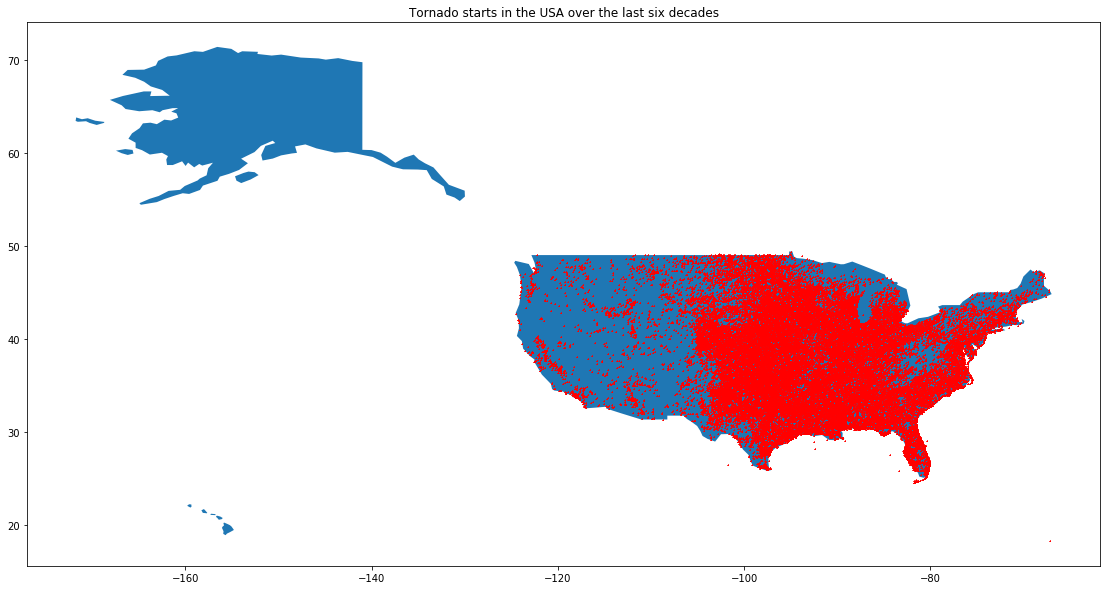

In [12]:
%%local

# NEW

# Load map of the world
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#Isolate the map of the United States
usa_bis=world[world['iso_a3'] == 'USA']

#Plot the tornado start coordinates on this map

fig, ax = plt.subplots(figsize=(20, 10))

usa_bis.plot(ax=ax)
geo_tornado.plot(ax=ax, markersize=1, marker='+', color='red')

plt.title('Tornado starts in the USA over the last six decades')

#fig.savefig('map2.png')

Here we see more clearly that the tornados of the last six decades mostly started in the East part of the USA. Let's make some more elaborated visualisations to see where in particular tornados tend to start.

Therefore, let's plot a heat map and a density map per state to have a different perspective on the data.

<a id="heatmap"></a>
### b. Heatmap: identify the hotspots

Here we plot a heat map which shows that most tornados seem to start in *middle* part of the US, not just the *East* part of the country.

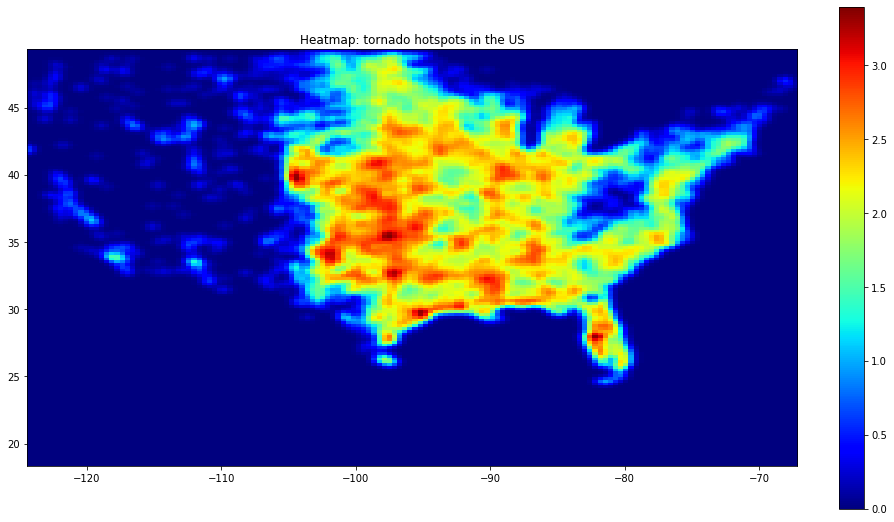

In [13]:
%%local

## Heatmap

# set size of the figure
pylab.rcParams['figure.figsize'] = 15, 12
# silence warnings
import warnings
warnings.filterwarnings("ignore")


def heatmap(d, grid=(150,150), smoothing=1, cmap='jet'):
    """
    Inputs
     * d: geodataframe containing Points
     * grid: how fine is the grid
     * smoothing: hyperparameter to obtain a smoothier image
     * cmap: colors
    Output
     * heat map (array displayed with matplotlib)    
    """
    
    longitude=list(d.SLON)
    latitude=list(d.SLAT)
    
    heatmap, xedges, yedges = np.histogram2d(latitude, longitude, bins=grid)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
    fig, ax = plt.subplots()

    log_heatmap = np.log(heatmap)
    log_heatmap[np.isneginf(log_heatmap)] = 0
    log_heatmap = ndimage.filters.gaussian_filter(log_heatmap, smoothing, mode='nearest')
    
    plt.title('Heatmap: tornado hotspots in the US')
    plt.imshow(log_heatmap, cmap=cmap, extent=extent)
    plt.colorbar(fraction=0.03)
    plt.gca().invert_yaxis()
    plt.show()
    #fig.savefig('heatmap.png')

    
heatmap(geo_tornado)

A higher concentration of tornados is visible in the orange and red areas. Dark blue corresponds to no tornado at all. A kind of tornado corridor seems to go through the middle of the US, particularly in Colorado, Nebraska, Arkansas and Texas.

These official NOAA Tornado density maps corroborate with our previous visualisation. 

![title](http://www.spc.noaa.gov/wcm/2015-wbc-anoms.png)

Now let's count the number of tornados per state and plot the corresponding density map.

<a id="density_map"></a>
### c. Density map per state: where the risk hides

#### Tornados per state

In [14]:
%%local

# Count number of tornados per state 
# NB: here directly using pd dataframes because error for visualisations when using PySpark kernel  

states = geo_tornado.ST.unique().tolist()

count=[]
for name in states:
    count.append(geo_tornado[geo_tornado['ST']==name].shape[0])

state_count={'count':count}

# Examples :
print('__Examples__')
print('Number of tornados registered in :')
print(' - New Jersey: '+str(count[states.index('NJ')]))
print(' - Kentucky: '+str(count[states.index('KY')]))
print(' - Alabama: '+str(count[states.index('AL')]))
print(' - Texas: '+str(count[states.index('TX')]))

state_count_df = pd.DataFrame(state_count, index=states)

__Examples__
Number of tornados registered in :
 - New Jersey: 142
 - Kentucky: 857
 - Alabama: 1896
 - Texas: 8197


#### Load map of the United States
Here we load a different, more precise map, with geographical coordinates of each state in the country. Please follow these steps:
1. download  cb_2018_us_state_5m.zip with this link: https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_5m.zip 
2. Move it to your current working directory (the directory of this notebook)
3. Unzip it. Keep its content in the same directory where our notebook also is.

Note we will explicitly load only the .shp file but all files from the original .zip must be kept in the same directory as the .shp. Open the .shp file with his local path.

Data from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html 

In [15]:
%%local

## Load USA shape file for the coming visualisations
usa = geopandas.read_file("cb_2018_us_state_5m.shp")

## alternative path (remote)
# usa = geopandas.read_file("/mnt/bludata0/scratch/Tornado_demo/cb_2018_us_state_5m.shp")

#### Merge USA states map with per state tornado count

Let's create a new geodataframe as the concatenation of the frequency dataframe and the above USA geodataframe.

In [16]:
%%local

# Rename column 'state_name' in geodataframe usa
usa.rename(columns={'STUSPS':'state_name'}, inplace=True)
# Set column 'state_name' as index 
temp=usa.set_index('state_name')

# Concatenate and set index as 'state_name'
result = pd.concat([state_count_df, temp], axis=1, sort=True).reindex(state_count_df.index)
print(type(result)) # <class 'pandas.core.frame.DataFrame'>
# we must go back to a geodataframe

# Convert result into a geodataframe
geometry=result['geometry']
geo_result=geopandas.GeoDataFrame(result, geometry=geometry)
print(type(geo_result)) # <class 'geopandas.geodataframe.GeoDataFrame'>

<class 'pandas.core.frame.DataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


Note that Alaska and some islands will disappear from the map since we merged the datasets by using state_count_df to set the index, which do not contain a row for these regions.

#### Display tornado density per US state

Text(0.5, 1, 'Occurrences per state')

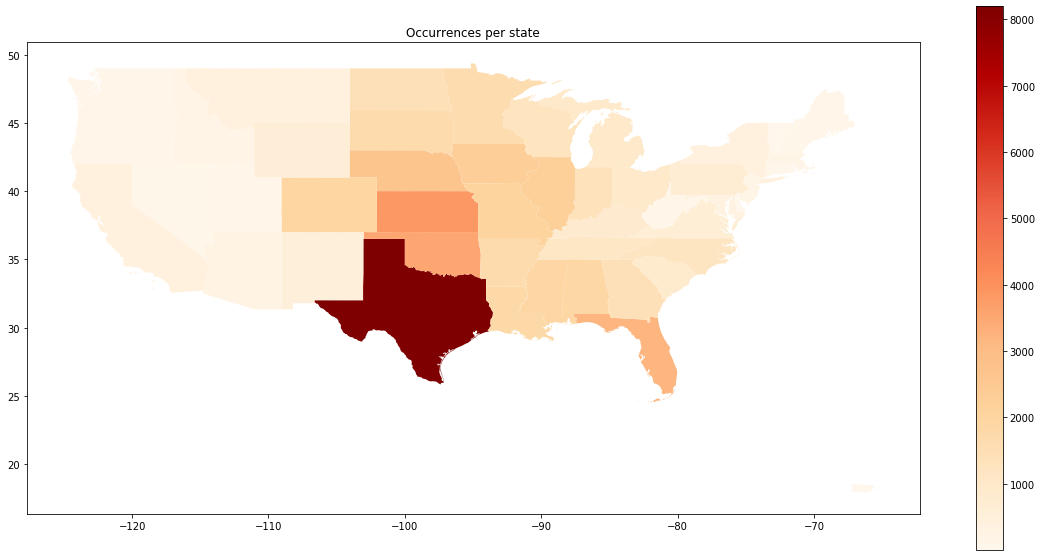

In [17]:
%%local

# Visualization 

fig, ax = plt.subplots(figsize=(20, 10))

geo_result.plot(column='count', ax=ax, legend=True, cmap='OrRd')

plt.title('Occurrences per state')

#fig.savefig('map4.png')

Well, now it's clear that Texas is the state which is the most tornado stricken of all states! It corroborates with the official maps above.
We can now focus on this particular state.

<a id="ML"></a>
## 4. Machine Learning : Tornado Clustering in Texas

From now on, we shall focus on Texas only.

We use a classic K-means algorithm to compute the coordinates of tornado clusters within Texas.

Let's filter the tornado records corresponding to Texas and remember how many we have:

In [18]:
input_texas = df.where("ST='TX'")
input_texas.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8197

We want to assign each insurance policy holder for real estate in Texas to a tornado cluster in Texas in order to caclulate a risk score. Elaborated risk scores can be defined according to the caracteristics of each cluster and the distance of the property from all clusters.

<a id="clusters_texas"></a>
### a. Build tornado clusters in Texas
Let's compute and plot the tornado clusters within Texas.

#### Training

We first select the features we want to train the model on. Here we based our model on Tornado latitude and longitude.

In [19]:
# Load data
assembler = VectorAssembler(
    inputCols=["SLAT","SLON"],
    outputCol="features")
newDF = assembler.transform(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now we define the model training stage for unsupervised cluster training using KMeans algorithm from Spark ML API. You can change the number of iterations as well as the number of cluster centers that should be detected. For demonstration purposes, the seed is specified for the cluster centers to start at the same point.

In [20]:
# Set model parameters
kmeans = KMeans().setK(4).setSeed(123)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Tornado clusters within the state of Texas

newDF_texas= assembler.transform(input_texas)
model_texas=kmeans.fit(newDF_texas)

predictions_texas = model_texas.transform(newDF_texas)
op_texas=predictions_texas.select("OBJECTID","SLON","SLAT","prediction")


#NOT-FOR-APP
# Number of tornados in each cluster
tornados_with_clusters_texas = op_texas.toDF("OBJECTID","SLON","SLAT","ClusterId")
count_texas=tornados_with_clusters_texas.groupBy("ClusterId").count().orderBy('ClusterID', ascending=True)
count_texas.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|ClusterId|count|
+---------+-----+
|        0| 2102|
|        1| 2768|
|        2| 1933|
|        3| 1394|
+---------+-----+

#### Prepare clusters data for visualisation

In [22]:
# Longitude and latitude of cluster centers

centers_texas = model_texas.clusterCenters()

arr_texas=np.array(centers_texas)
print("Cluster Centers in Texas: (longitude, latitude)")
for i in range(len(arr_texas)):
    print(' - Cluster '+str(i)+' has coordinates ' +str((arr_texas[i][1],arr_texas[i][0])))

longitude_texas=arr_texas[:,1]
latitude_texas=arr_texas[:,0]

coord_texas={'longitude':longitude_texas, 'latitude':latitude_texas}

clusters_texas=pd.DataFrame(coord_texas)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cluster Centers in Texas: (longitude, latitude)
 - Cluster 0 has coordinates (-98.12105071292775, 32.556328707224324)
 - Cluster 1 has coordinates (-101.63892733188719, 33.89452870571222)
 - Cluster 2 has coordinates (-95.09172659079152, 31.15349451629592)
 - Cluster 3 has coordinates (-97.80616750358682, 28.79354971305595)

In [23]:
#NOT-FOR-APP
# Add column with number of torndos per cluster to the dataframe containing their coordinates.
clusters_texas['count']=count_texas.toPandas()['count']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**TempView**: Texas clusters

Remember the 3 steps we have already performed on the tornado dataset.

In [24]:
#NOT-FOR-APP
sqlContext.createDataFrame(clusters_texas).createOrReplaceTempView('texas_clusters')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
%%sql -o texas_clusters -n -1 
SELECT * FROM texas_clusters

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

#### Display location of cluster centers with size

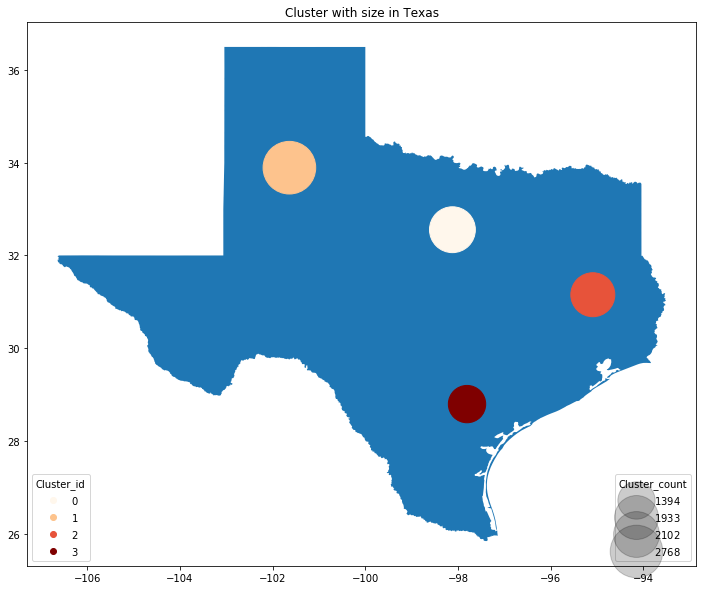

In [26]:
%%local

lon_lat=[Point(x, y) for x, y in zip(texas_clusters.longitude, texas_clusters.latitude)]
geo_cluster=geopandas.GeoDataFrame(texas_clusters, geometry=lon_lat)

# Isolate Texas map

texas=usa.loc[usa['NAME'] == 'Texas']

# Plot 

x, y = texas_clusters.longitude, texas_clusters.latitude
c = texas_clusters.index
s = texas_clusters['count']

fig, ax = plt.subplots(figsize=(20,10))

texas.plot(ax=ax)

scatter = ax.scatter(x, y, c=c, s=s, cmap='OrRd')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster_id")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.2)
legend2 = ax.legend(handles, labels, loc="lower right", title="Cluster_count")


plt.title('Cluster with size in Texas')
plt.show()
#fig.savefig('clusters2')

Here we can see in where the cluster centers of the Texas tornados are located. The size of each bullet indicates the number of tornados belonging to the cluster. But a cluster center is not all. What about the shape of the clusters? Their actual surface ? Let's visualize it.

#### Visualize cluster shapes

In the following steps, we will plot both cluster centers and their belonging tornados, so that we get an idea of the repartition of tornados across Texas, not only across clusters (cluster size) but also within clusters. We get a better view of the territorial scope and shape of each cluster.

First we create a Spark Dataframe for tornados with an additional 'ClusterID' column. Then we pull this data to our local environment in order to plot the visualisations locally.

In [27]:
#Label the tornados

tor= assembler.transform(input_texas)

predictions_tor = model_texas.transform(tor)
select_pred_tor=predictions_tor.select("ST","SLON","SLAT","prediction")
pred_tor = select_pred_tor.toDF("ST", "SLON", "SLAT", "ClusterID")
pred_tor.show(3)
pred_tor.groupBy("ClusterId").count().orderBy('count', ascending=False).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+------+-----+---------+
| ST|  SLON| SLAT|ClusterID|
+---+------+-----+---------+
| TX|-98.08|27.75|        3|
| TX|-97.57|33.08|        0|
| TX|-97.15| 33.6|        0|
+---+------+-----+---------+
only showing top 3 rows

+---------+-----+
|ClusterId|count|
+---------+-----+
|        1| 2768|
|        0| 2102|
|        2| 1933|
|        3| 1394|
+---------+-----+

In [28]:
# Create a TempView for visualization
pred_tor.createOrReplaceTempView('labeled_tornados')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
%%sql -o labeled_tornados -n -1 
SELECT * FROM labeled_tornados

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

Display cluster with shape

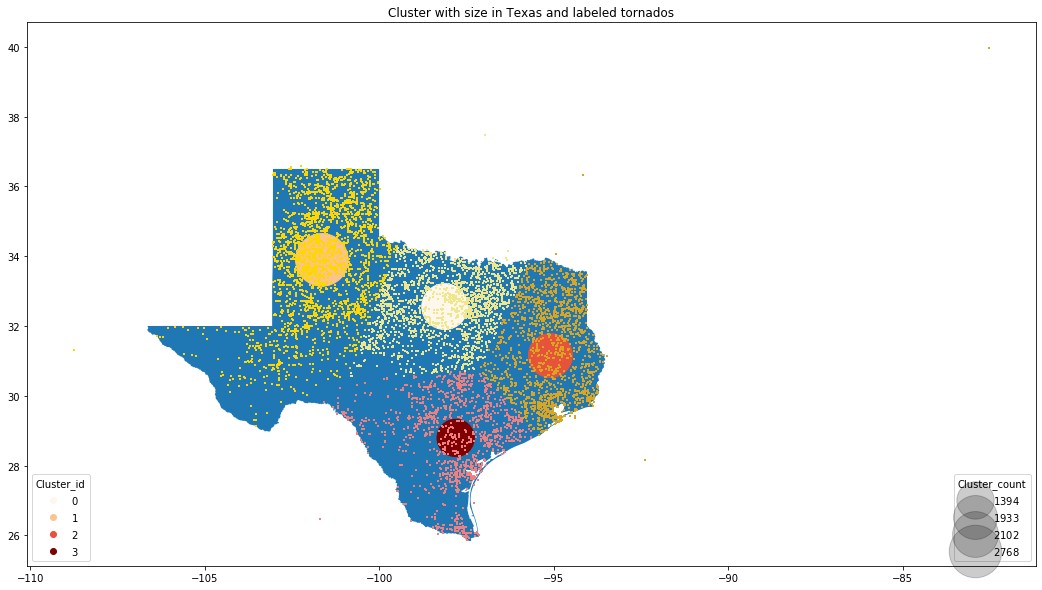

In [30]:
%%local

# GeoDataFrame for cluster centers
lon_lat_clusters=[Point(x, y) for x, y in zip(texas_clusters.longitude, texas_clusters.latitude)]
geo_cluster=geopandas.GeoDataFrame(texas_clusters, geometry=lon_lat_clusters)

#GeoDataFrame for labeled tornados
lon_lat_tor=[Point(x, y) for x, y in zip(labeled_tornados.SLON, labeled_tornados.SLAT)]
geo_tor=geopandas.GeoDataFrame(labeled_tornados, geometry=lon_lat_tor)

# Isolate Texas map
texas=usa.loc[usa['NAME'] == 'Texas']

### Plot ###

fig, ax = plt.subplots(figsize=(20,10))

# Texas map
texas.plot(ax=ax)

# Cluster centers
x, y = texas_clusters.longitude, texas_clusters.latitude
c = texas_clusters.index
s = texas_clusters['count']
scatter = ax.scatter(x, y, c=c, s=s, cmap='OrRd')

# Labeled tornados
colors=['khaki','gold', 'goldenrod', 'lightcoral', 'beige', 'darkkhaki', 
        'honeydew', 'lavender', 'seeshell', 'linen'][:len(texas_clusters)]
for i in range(len(texas_clusters)):
    geo_tor[geo_tor['ClusterID']==i].plot(ax=ax, markersize=5, marker='+', color=colors[i])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster_id")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.2)
legend2 = ax.legend(handles, labels, loc="lower right", title="Cluster_count")


plt.title('Cluster with size in Texas and labeled tornados')
plt.show()
#fig.savefig('clusters2')

Here we realize that some tornado records seem to be misclasified, as their starting location is outside of Texas. Nonetheless, they may have been labeled as tornados in Texas if they went through this state and caused damages there too. Cluster 0 is more sparse than the others, Cluster 3 has the highest concentration... You can associate a different level of risk to each cluster on the basis of its caracteristics.

<a id="insurance_holders"></a>
### b. Assess risk of home insurance holders in Texas

#### Load the insurance holders data

Note that this data is made up for the sake of this demo.

In [31]:
#Load the data
insurance_holders = spark.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="TEXAS_CUSTOMERS") \
        .load()
insurance_holders.show(5)
insurance_holders.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------------+---------------+-------------------+------------------+
|OBJECTID|           NAME|INSURANCE_VALUE|                LON|               LAT|
+--------+---------------+---------------+-------------------+------------------+
|  268088| Mathew Lefebre|         792520|-100.17960181047516| 35.96859913214428|
|  268107|  Erinn Blacker|         153039|-100.04261816099927| 35.72081943826652|
|  268108|Jacquline Ivery|         147671|-100.11137833174456|36.049429294726224|
|  268068|Augustine Logue|         248946|-100.07705352500017| 35.87356015787503|
|  885775|Diedre Currence|         679625|-100.19422553248228| 35.99589853668817|
+--------+---------------+---------------+-------------------+------------------+
only showing top 5 rows

83663

In [32]:
# OPTIONAL
# Again, you can use only a sample of the data if you like, but you should be able to 
# run the folllowing cells only in a few seconds. 
sample_insurance_holders=insurance_holders.sample(False, 0.2, 42)
# If you want, replace insurance_holders by sample_insurance_holders in the TempView step. 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Assign customers to their nearest tornado cluster

Finally, we run a prediction with the tornado cluster model on the insurance holders to assign each one to its nearest tornado cluster. We then print a sample of the result.

In [33]:
# Rearrange the Spark DataFrame at your convenience
# Here we change the column names and their order.
insurance_holders_renamed = insurance_holders.toDF("OBJECTID", "NAME", "INSURANCE_VALUE", "SLON", "SLAT")
# insurance_holders_renamed_rearr = insurance_holders_renamed.select("OBJECTID", "NAME", "INSURANCE_VALUE", "SLAT", "SLON")

# Train
newDF_inc= assembler.transform(insurance_holders_renamed)
# model_inc=kmeans.fit(newDF_inc)

predictions_inc = model_texas.transform(newDF_inc)
op_inc=predictions_inc.select("OBJECTID", "NAME", "INSURANCE_VALUE", "SLON","SLAT","prediction")
inc_with_clusters = op_inc.toDF("OBJECTID", "NAME", "INSURANCE_VALUE", "SLON", "SLAT", "ClusterID")
inc_with_clusters.show(3)
inc_with_clusters.groupBy("ClusterId").count().orderBy('count', ascending=False).show()

#Printing the results
print("Writing results to table TEXAS_CUSTOMERS_SCORED ...")
df.registerTempTable("TEXAS_CUSTOMERS_SCORED")
print('Done')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------------+---------------+-------------------+------------------+---------+
|OBJECTID|           NAME|INSURANCE_VALUE|               SLON|              SLAT|ClusterID|
+--------+---------------+---------------+-------------------+------------------+---------+
|  268088| Mathew Lefebre|         792520|-100.17960181047516| 35.96859913214428|        1|
|  268107|  Erinn Blacker|         153039|-100.04261816099927| 35.72081943826652|        1|
|  268108|Jacquline Ivery|         147671|-100.11137833174456|36.049429294726224|        1|
+--------+---------------+---------------+-------------------+------------------+---------+
only showing top 3 rows

+---------+-----+
|ClusterId|count|
+---------+-----+
|        1|27748|
|        2|19070|
|        0|18784|
|        3|18061|
+---------+-----+

Writing results to table TEXAS_CUSTOMERS_SCORED ...
Done

**TempView** : Texas customers

In [34]:
#NOT-FOR-APP
# insurance_holders: whole dataset
# sample_insurance_holders: only a subset
inc_with_clusters.createOrReplaceTempView('insurance_holders')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
%%sql -o insurance_holders --maxrows -1
SELECT * FROM insurance_holders 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

#### Display: Customers and clusters 
In grey, you can see where insurance holders are located.

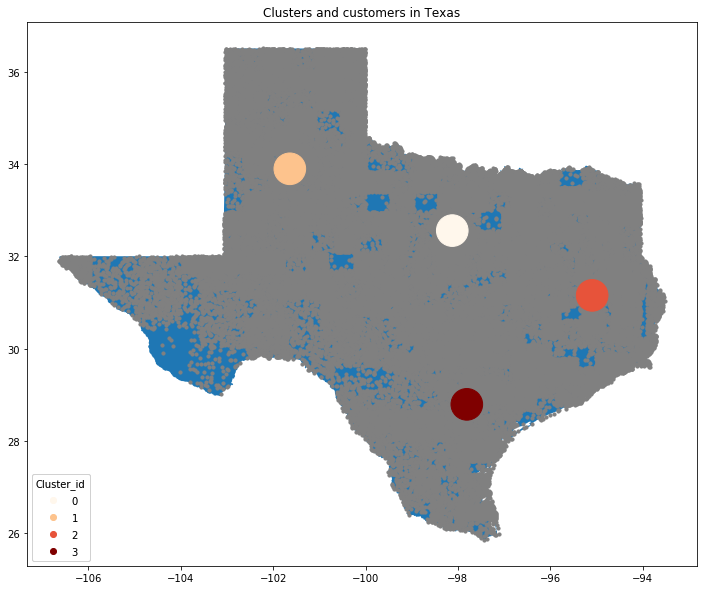

In [36]:
%%local

# Let's make geopoints out of this new data
lon_lat=[Point(x, y) for x, y in zip(insurance_holders.SLON, insurance_holders.SLAT)]
insurance_holders=geopandas.GeoDataFrame(insurance_holders, geometry=lon_lat)

# Let's plot it 

fig, ax = plt.subplots(figsize=(20,10))
x, y = texas_clusters.longitude, texas_clusters.latitude
c = texas_clusters.index
#s = texas_clusters.cluster_count

texas.plot(ax=ax) # map
insurance_holders.plot(ax=ax, markersize=10, color='grey') # insurance holders
scatter = ax.scatter(x, y, c=c, s=1000, cmap='OrRd') # clusters 

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster_id")
ax.add_artist(legend1)

plt.title('Clusters and customers in Texas')

plt.show()

Now we want to see which insurance holder is closest to which cluster.

#### Highlight the customers belonging to each cluster

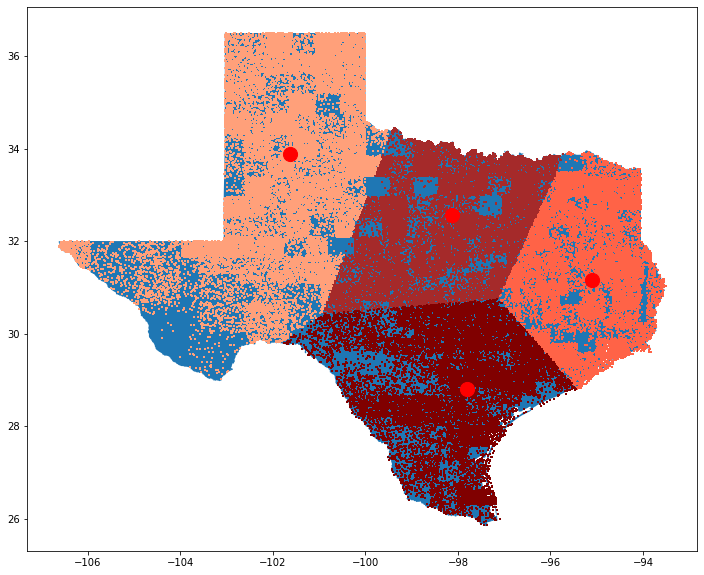

In [37]:
%%local

# Plot with color code

# isolate each group and plot it with a different graphic code

fig, ax = plt.subplots(figsize=(20,10))

texas.plot(ax=ax)


colors=['brown','lightsalmon', 'tomato', 'maroon', 'peachpuff', 'indianred', 'mistyrose', 'seeshell', 'linen'][:len(texas_clusters)]

for i in range(len(texas_clusters)):
    insurance_holders[insurance_holders['ClusterID']==i].plot(ax=ax, markersize=5, marker='+', color=colors[i])

texas_clusters=geopandas.GeoDataFrame(texas_clusters, geometry=[Point(x, y) for x, y in zip(texas_clusters.longitude, texas_clusters.latitude)])
texas_clusters.plot(ax=ax, markersize=200, marker='o', color='red')

Note: We have materialized the Voroinoi cells.

#### Visualise the price paid by each household 
Could be a development of this use case... Your turn to code! 
1. define rule of insurance policy
2. apply rule on your data
3. visualize

Where to go from here?

<a id="you"></a>
## 5. Deploy your application with your own data

You can easily deploy the essential logic of this notebook as an application that can be run at any time via a dashDB [stored procedure](https://www.ibm.com/support/knowledgecenter/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_spark_applications_functions.html) invokation, via dashDB's command line [spark-submit.sh](https://www.ibm.com/support/knowledgecenter/SS6NHC/com.ibm.swg.im.dashdb.doc/learn_how/spark_ref.html) or via a [REST API](https://developer.ibm.com/clouddataservices/wp-content/themes/projectnext-clouddata/dashDBanalytics/#/).

Note that a few cells above have the __`#NOT-FOR-APP`__ comment. Cells with this comment as well as cells that only contain Jupyter cell magic starting with __`%%`__ are automatically skipped when deploying the notebook as an application. This way you can organize your notebook for interactive vs. backend logic.

In order to generate and deploy an application for this notebook select __`File->Deploy as->Deploy to dashDB Spark`__ in the menu above. After a short while it shows you the result page for the deployment with the specific invocation options that you just can copy and past to try them out immediately.

## What you've learned

Congratulations! 

You've successfully learned how to:
* connect to Db2 and launch a Spark session through livy
* add or retrieve data from Db2, anytime and anywhere
* analyze data with PySpark
* create a temporary view of a Spark dataframe
* visualize geographic data locally using matplotlib and geopandas for risk assessment

You can now easily deploy your own application and run it anytime on IBM Db2!

___
## Authors

__Eva Feillet__ is intern at IBM Research Lab in Böblingen. She comes from CentraleSupelec Engineering School in France and has studied deep learning at the Technical University of Munich. She is passionnate about data science and eager to apply it to real-life use cases.

__Toni Bollinger__

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.